# Project Phase 2
## Mohammad Amin Rami 98101588
## Milad Heidari 98101469
## Mohammad Reza Safavi 98106701

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
import string
import random
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

### A custom dataset class

In [2]:
class MSCTD(Dataset):
    def __init__(self, root='data', mode='train', transform=None, target_transform=None):
        self.root = root
        self.mode = mode
        self.transform = transform
        self.target_transform = target_transform
        self.data_dir = os.path.join(self.root, 'MSCTD', self.mode, 'texts')
        self.texts = []
        self.targets = []
        self.read_data()

    
    def read_data(self):
        with open(os.path.join(self.data_dir, f'english_{self.mode}.txt')) as file:
            for sentence in file:
                sentence = MSCTD.pre_processing(sentence)
                self.texts.append(sentence)
                
        with open(os.path.join(self.data_dir, f'sentiment_{self.mode}.txt')) as file:
            for sentiment in file:
                self.targets.append(int(sentiment.strip()))   
    
    @staticmethod
    def pre_processing(sentence: str):
        sentence = sentence.strip().lower().translate(str.maketrans('', '', string.punctuation))
        sentence = sentence.split(' ')
        sentence = [word for word in sentence if word not in stopwords.words('english')]
        sentence = " ".join(sentence)
        return sentence
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        text = self.texts[index]
        target = self.targets[index]
        if self.transform is not None:
            text = self.transform(text)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return (text, target)


In [3]:
train_data = MSCTD()
test_data = MSCTD(mode='test')

In [44]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_data.texts)
train_data.transform = lambda x: torch.Tensor(vectorizer.transform([x]).toarray()).to(device).reshape((-1, ))
test_data.transform = lambda x: torch.Tensor(vectorizer.transform([x]).toarray()).to(device).reshape((-1, ))

In [25]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

### TF-IDf based classification of sentences

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(128, 3)
        )
        
    def forward(self, x):
        return self.stack(x)



In [47]:
input_dim = len(vectorizer.get_feature_names_out())
model = MLP(input_dim=input_dim).to(device)

In [9]:
model.train()

MLP(
  (stack): Sequential(
    (0): Linear(in_features=10180, out_features=1024, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=128, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [10]:
learning_rate = 1e-4
epochs = 2
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    k = int(size/dataloader.batch_size/5)

    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % k == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [12]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    try:
        train_loop(train_loader, model, loss_fn, optimizer)
        test_loop(test_loader, model, loss_fn)
    except KeyboardInterrupt:
        print('Training interrupted')
print("Done!")

Epoch 1
-------------------------------
loss: 1.100943  [    0/20240]
loss: 1.093597  [ 4032/20240]
loss: 1.068672  [ 8064/20240]
loss: 1.092833  [12096/20240]
loss: 1.069563  [16128/20240]
loss: 1.123721  [20160/20240]
Test Error: 
 Accuracy: 43.5%, Avg loss: 1.065164 

Epoch 2
-------------------------------
loss: 1.042845  [    0/20240]
loss: 1.052313  [ 4032/20240]
loss: 1.168628  [ 8064/20240]
loss: 1.015469  [12096/20240]
loss: 1.027939  [16128/20240]
loss: 1.055000  [20160/20240]
Test Error: 
 Accuracy: 51.4%, Avg loss: 1.001382 

Done!


In [50]:
#torch.save(model, 'phase2mlp.pt')

#### Classification metrics

============ Classification metrics ============
              precision    recall  f1-score   support

           0       0.36      0.39      0.38      1298
           1       0.56      0.72      0.63      2163
           2       0.61      0.33      0.43      1606

    accuracy                           0.51      5067
   macro avg       0.51      0.48      0.48      5067
weighted avg       0.52      0.51      0.50      5067

AxesSubplot(0.125,0.11;0.62x0.77)


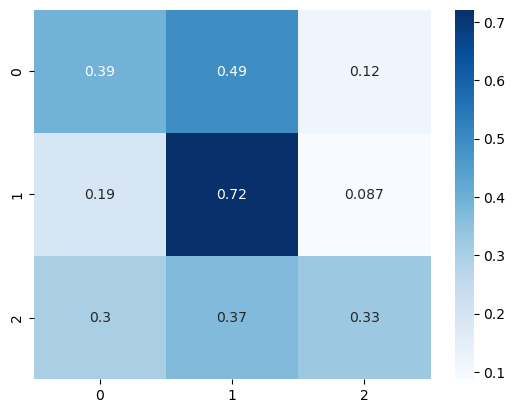

In [49]:
pred = None
g_truth = None
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        if pred is None:
            pred = model(X.float()).argmax(dim=1).reshape((-1, ))
            g_truth = y
        else:
            pred = torch.cat((pred, model(X.float()).argmax(dim=1).reshape((-1, ))))
            g_truth = torch.cat((g_truth, y))

print('============ Classification metrics ============')
print(classification_report(g_truth.cpu(), pred.cpu()))
print(sns.heatmap(confusion_matrix(g_truth.cpu(), pred.cpu(),  normalize='true'), annot=True, cmap='Blues'))


### Classification Using SVM based vectorization

In [6]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_data.texts)

TfidfVectorizer()

In [7]:
word2vec = {word: {"vec": np.zeros((len(vectorizer.get_feature_names_out()), )), "count": 0} for word in vectorizer.get_feature_names_out()}

In [8]:
train_data.transform = None
test_data.transform = None
for i in tqdm(range(len(train_data))):
    text, _ = train_data[i]
    if len(text.split()) == 0:
        continue
    else:
        svm_model = SVC()
        class1_vectors = [vectorizer.transform([word]).toarray() for word in text.split()]
        X1 = np.concatenate(class1_vectors, axis=0)
        y1 = np.array([1 for _ in range(X1.shape[0])])
        
        random_text, _ = random.choice(train_data)
        while len(random_text.split()) == 0:
            random_text, _ = random.choice(train_data)
        
        class2_vectors = [vectorizer.transform([word]).toarray() for word in random_text.split()]
        X2 = np.concatenate(class2_vectors, axis=0)
        y2 = np.array([-1 for _ in range(X2.shape[0])])
        svm_model.fit(np.concatenate((X1, X2), axis=0), np.concatenate((y1, y2)))
        
        for index, word in enumerate(text.split()):
            vec = svm_model.support_vectors_[np.where(svm_model.support_ == index), :].reshape((-1, ))
            if len(vec) == 0:
                continue
            try:
                word2vec[word]['vec'] = (word2vec[word]['count'] * word2vec[word]['vec'] + vec)/(word2vec[word]['count'] + 1)
                word2vec[word]['count'] = word2vec[word]['count'] + 1 
            except KeyError:
                pass
            


100%|████████████████████████████████████| 20240/20240 [01:13<00:00, 274.71it/s]


In [9]:
def word2vec_transformer(text):
    vecs = [torch.Tensor(word2vec[word]['vec']) for word in text.split() if word in word2vec]
    if len(vecs) == 0:
        return torch.zeros((len(vectorizer.get_feature_names_out()), ))
    return sum(vecs)

In [10]:
input_dim = len(vectorizer.get_feature_names_out())
mlp_svm = MLP(input_dim=input_dim).to(device)
mlp_svm.train()

MLP(
  (stack): Sequential(
    (0): Linear(in_features=10180, out_features=1024, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=128, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [11]:
train_data.transform = word2vec_transformer
test_data.transform = word2vec_transformer

In [12]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [13]:
learning_rate = 1e-4
epochs = 2
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_svm.parameters(), lr=learning_rate)

In [14]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    try:
        train_loop(train_loader, mlp_svm, loss_fn, optimizer)
        test_loop(test_loader, mlp_svm, loss_fn)
    except KeyboardInterrupt:
        print('Training interrupted')
print("Done!")

Epoch 1
-------------------------------
loss: 1.095055  [    0/20240]
loss: 1.106707  [ 4032/20240]
loss: 1.086718  [ 8064/20240]
loss: 1.064128  [12096/20240]
loss: 1.017172  [16128/20240]
loss: 1.066844  [20160/20240]
Test Error: 
 Accuracy: 46.1%, Avg loss: 1.050800 

Epoch 2
-------------------------------
loss: 1.039099  [    0/20240]
loss: 0.941680  [ 4032/20240]
loss: 1.046713  [ 8064/20240]
loss: 0.981010  [12096/20240]
loss: 0.767623  [16128/20240]
loss: 0.988457  [20160/20240]
Test Error: 
 Accuracy: 50.9%, Avg loss: 0.999387 

Done!


In [16]:
#torch.save(mlp_svm, 'phase2mlp_svm.pt')

#### Classification metrics

============ Classification metrics ============
              precision    recall  f1-score   support

           0       0.37      0.54      0.44      1298
           1       0.59      0.62      0.60      2163
           2       0.62      0.35      0.44      1606

    accuracy                           0.51      5067
   macro avg       0.52      0.50      0.49      5067
weighted avg       0.54      0.51      0.51      5067

AxesSubplot(0.125,0.11;0.62x0.77)


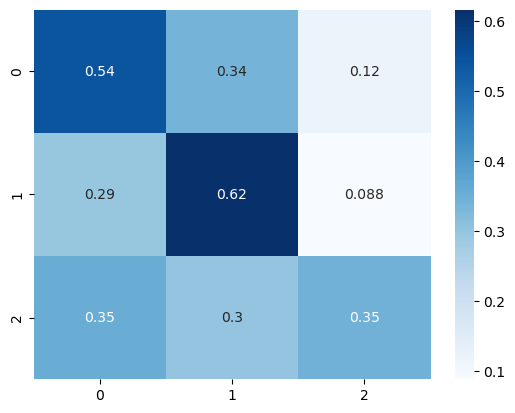

In [19]:
pred = None
g_truth = None
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        if pred is None:
            pred = mlp_svm(X.float()).argmax(dim=1).reshape((-1, ))
            g_truth = y
        else:
            pred = torch.cat((pred, mlp_svm(X.float()).argmax(dim=1).reshape((-1, ))))
            g_truth = torch.cat((g_truth, y))

print('============ Classification metrics ============')
print(classification_report(g_truth.cpu(), pred.cpu()))
print(sns.heatmap(confusion_matrix(g_truth.cpu(), pred.cpu(),  normalize='true'), annot=True, cmap='Blues'))

### Classification using GloVe vectorization 

In [51]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 3)
        
    def forward(self, x, h):
        output, hidden = self.lstm(x, h)
        output = self.linear(output)
        return output, hidden



In [52]:
glove_dict = {}
with open('GloVe/glove.6B.50d.txt') as file:
    for line in file:
        data = line.split(' ')
        word = data[0]
        tensor = torch.Tensor([float(num) for num in data[1:]]).to(device)
        tensor = tensor.reshape((1, -1))
        glove_dict[word] = tensor


In [53]:
def sentence2tensor(sentence):
    words = sentence.split(' ')
    words = [word for word in words if word in glove_dict]
    if len(words) == 0:
        return torch.zeros_like(glove_dict['the'])
    return torch.cat([glove_dict[word] for word in words], dim=0)

train_data.transform = sentence2tensor
test_data.transform = sentence2tensor

In [54]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    k = int(size/dataloader.batch_size/5)
    
    for batch, (X, y) in enumerate(dataloader):
        hidden_state = (torch.zeros((1, model.hidden_size)).to(device), torch.zeros((1, model.hidden_size)).to(device))
        seq_len = X.shape[1]
        y = y.to(device)
        X = X.reshape((seq_len, model.input_size))
        for i in range(seq_len):
            x = torch.reshape(X[i, :], (1, -1)).to(device)
            pred, hidden_state = model(x, hidden_state)

        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % k == 0:
            loss, current = loss.item(), batch 
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            hidden_state = (torch.zeros((1, model.hidden_size)).to(device), torch.zeros((1, model.hidden_size)).to(device))
            y = y.to(device)
            seq_len = X.shape[1]
            X = X.reshape((seq_len, model.input_size))
            for i in range(seq_len):
                x = torch.reshape(X[i, :], (1, -1)).to(device)
                pred, hidden_state = model(x, hidden_state)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [55]:
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1)

In [34]:
rnn_model = LSTMClassifier(50, 64).to(device)
rnn_model.train()

LSTMClassifier(
  (lstm): LSTM(50, 64)
  (linear): Linear(in_features=64, out_features=3, bias=True)
)

In [35]:
learning_rate = 1e-4
epochs = 6
loss_fn = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

In [36]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    try:
        train_loop(train_loader, rnn_model, loss_fn, rnn_optimizer)
        test_loop(test_loader, rnn_model, loss_fn)
    except KeyboardInterrupt:
        print('Training interrupted')
        break
print("Done!")

Epoch 1
-------------------------------
loss: 1.067810  [    0/20240]
loss: 1.267462  [ 4048/20240]
loss: 1.057291  [ 8096/20240]
loss: 1.797629  [12144/20240]
loss: 1.021151  [16192/20240]
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.010462 

Epoch 2
-------------------------------
loss: 1.525786  [    0/20240]
loss: 0.578536  [ 4048/20240]
loss: 0.581900  [ 8096/20240]
loss: 1.418229  [12144/20240]
loss: 1.044232  [16192/20240]
Test Error: 
 Accuracy: 48.9%, Avg loss: 1.021867 

Epoch 3
-------------------------------
loss: 0.625332  [    0/20240]
loss: 1.489163  [ 4048/20240]
loss: 0.293975  [ 8096/20240]
loss: 2.040463  [12144/20240]
loss: 0.744247  [16192/20240]
Test Error: 
 Accuracy: 50.8%, Avg loss: 0.999170 

Epoch 4
-------------------------------
loss: 0.658907  [    0/20240]
loss: 0.874412  [ 4048/20240]
loss: 1.812984  [ 8096/20240]
loss: 0.548415  [12144/20240]
loss: 0.563508  [16192/20240]
Test Error: 
 Accuracy: 50.8%, Avg loss: 0.996476 

Epoch 5
------------------------

In [57]:
#torch.save(rnn_model, 'phase2rnn.pt')

#### Classification metrics

============ Classification metrics ============
              precision    recall  f1-score   support

           0       0.39      0.53      0.45      1298
           1       0.56      0.63      0.60      2163
           2       0.62      0.33      0.43      1606

    accuracy                           0.51      5067
   macro avg       0.52      0.50      0.49      5067
weighted avg       0.54      0.51      0.51      5067

AxesSubplot(0.125,0.11;0.62x0.77)


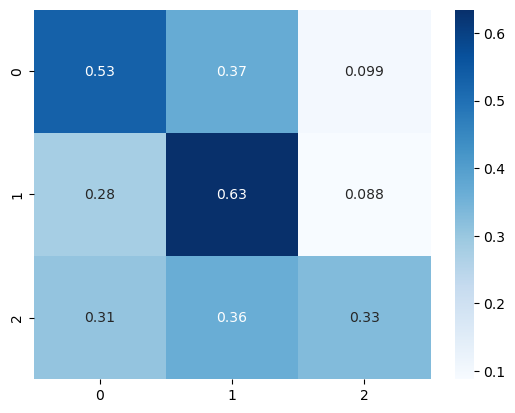

In [58]:
g_truth = None
pred = None
with torch.no_grad():
    for X, y in test_loader:
        hidden_state = (torch.zeros((1, rnn_model.hidden_size)).to(device), torch.zeros((1, rnn_model.hidden_size)).to(device))
        y = y.to(device)
        seq_len = X.shape[1]
        X = X.reshape((seq_len, rnn_model.input_size))
        for i in range(seq_len):
            x = torch.reshape(X[i, :], (1, -1)).to(device)
            output, hidden_state = rnn_model(x, hidden_state)
        if pred is None:
            pred = output.argmax(dim=1).reshape((-1, ))
            g_truth = y
        else:
            pred = torch.cat((pred, output.argmax(dim=1).reshape((-1, ))))
            g_truth = torch.cat((g_truth, y))

print('============ Classification metrics ============')
print(classification_report(g_truth.cpu(), pred.cpu()))
print(sns.heatmap(confusion_matrix(g_truth.cpu(), pred.cpu(),  normalize='true'), annot=True, cmap='Blues'))

### Classification using Bert

In [14]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased'
)
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:
train_data.transform = lambda text: tokenizer(text, padding='max_length', max_length=25, truncation=True, return_tensors='pt') 
test_data.transform = lambda text: tokenizer(text, padding='max_length', max_length=25, truncation=True, return_tensors='pt') 

In [16]:
learning_rate = 3e-5
batch_size = 16
epochs = 3

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=learning_rate, eps=1e-8)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    k = int(size/dataloader.batch_size/5)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        losses = []
        # forward prop
        y = y.to(device)
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        output = model(
            input_ids=input_id,
            attention_mask=mask,
            labels=y)
        loss = output.loss
        logits = output.logits
        losses.append(loss.item())
        num_correct += (logits.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num % k == 0:
            print(f'batch: {batch_num}, loss: {np.mean(losses):.6f}')
            losses = []
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item():.6f}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            y = y.to(device)
            mask = X['attention_mask'].to(device)
            input_id = X['input_ids'].squeeze(1).to(device)
            output = model(
                input_ids=input_id,
                attention_mask=mask,
                labels=y)
            logits = output.logits
            num_correct += (logits.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [19]:
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_loop(train_dataloader, bert_model, loss_fn, optimizer)
    test_loop(test_dataloader, bert_model, loss_fn)
    print()

Epoch 1
-------------------------------
batch: 0, loss: 1.105547
batch: 253, loss: 1.006641
batch: 506, loss: 1.019125
batch: 759, loss: 0.797804
batch: 1012, loss: 1.151245
train_loss: 0.710837
Train Accuracy: 54.15%
Test Accuracy: 54.47%

Epoch 2
-------------------------------
batch: 0, loss: 0.819278
batch: 253, loss: 0.976935
batch: 506, loss: 1.249068
batch: 759, loss: 0.914047
batch: 1012, loss: 1.160728
train_loss: 0.705366
Train Accuracy: 62.75%
Test Accuracy: 54.96%

Epoch 3
-------------------------------
batch: 0, loss: 0.547316
batch: 253, loss: 0.925916
batch: 506, loss: 0.779455
batch: 759, loss: 1.050637
batch: 1012, loss: 0.806697
train_loss: 0.908105
Train Accuracy: 71.63%
Test Accuracy: 53.9%



In [24]:
#torch.save(bert_model, 'pahse2bert.pt')

#### Classification metrics


============ Classification metrics ============
              precision    recall  f1-score   support

           0       0.40      0.60      0.48      1298
           1       0.65      0.58      0.61      2163
           2       0.59      0.44      0.50      1606

    accuracy                           0.54      5067
   macro avg       0.55      0.54      0.53      5067
weighted avg       0.57      0.54      0.54      5067

AxesSubplot(0.125,0.11;0.62x0.77)


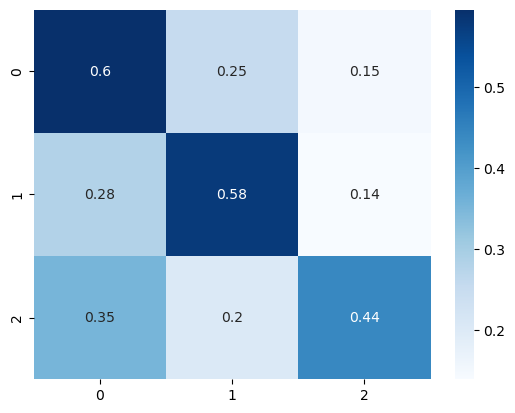

In [22]:
g_truth = None
pred = None
with torch.no_grad():
    for batch_num, (X, y) in enumerate(test_dataloader):
        y = y.to(device)
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        output = bert_model(
            input_ids=input_id,
            attention_mask=mask,
            labels=y)
        logits = output.logits
        if pred is None:
            pred = logits.argmax(dim=1).reshape((-1, ))
            g_truth = y
        else:
            pred = torch.cat((pred, logits.argmax(dim=1).reshape((-1, ))))
            g_truth = torch.cat((g_truth, y))

        
print('============ Classification metrics ============')
print(classification_report(g_truth.cpu(), pred.cpu()))
print(sns.heatmap(confusion_matrix(g_truth.cpu(), pred.cpu(),  normalize='true'), annot=True, cmap='Blues'))